In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os
import sys

import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
count = pd.read_csv("./data/GSE147747_expr_raw_counts_table.tsv",
                    sep="\t", index_col=0)

In [4]:
meta = pd.read_csv("./data/GSE147747_meta_table.tsv",
                   sep="\t", index_col=0)

In [8]:
adata_st_all = ad.AnnData(X = count.values)
adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

meta_slice = pd.read_csv("./data/figures/slicestable.tsv",
                        index_col=0, sep="\t")
slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
slice_dist_micron = [-(slice_AP[i+1] - slice_AP[i]) for i in range(len(slice_AP)-1)]

adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
sc.pp.filter_cells(adata_st_all, min_genes=1)

adata_st_all.obsm['spatial'] = np.concatenate((adata_st_all.obs['HE_X'].values.reshape(-1, 1),
                                               adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

adata_st_list_raw = []

for slice_id in sorted(set(adata_st_all.obs.section_index.values)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index.values == slice_id]

    array_col = np.array([np.float_(loc.split("_")[1].split("x")[0]) for loc in adata_st_i.obs.index])
    if slice_id == '01A':
        array_col = array_col - 0.3
    array_row = np.array([np.float_(loc.split("_")[1].split("x")[1]) for loc in adata_st_i.obs.index])

    adata_st_i.obs['array_col'] = np.round(array_col)
    adata_st_i.obs['array_row'] = np.round(array_row)
    adata_st_i.obsm['loc_use'] = np.concatenate((adata_st_i.obs['array_row'].values.reshape(-1, 1),
                                                 adata_st_i.obs['array_col'].values.reshape(-1, 1)), axis=1)

    adata_st_list_raw.append(adata_st_i.copy())

for i in range(1, 6): # adjust spatial locations
    adata_st_list_raw[i].obsm['loc_use'] = np.concatenate((adata_st_list_raw[i].obsm['loc_use'][:, 0].reshape(-1, 1),
                                                           2*np.mean(adata_st_list_raw[i].obsm['loc_use'][:, 1])-adata_st_list_raw[i].obsm['loc_use'][:, 1].reshape(-1, 1)), axis=1)

In [9]:
adata_ref = ad.read_h5ad("./data/MouseBrain/all_cells_20200625.h5ad")
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique()
labels = pd.read_csv("./data/MouseBrain/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0)

labels = labels.reindex(index=adata_ref.obs_names)
adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

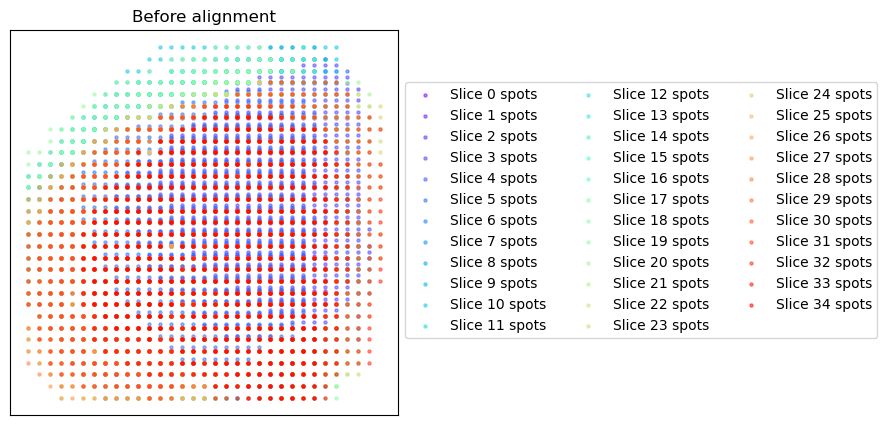

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


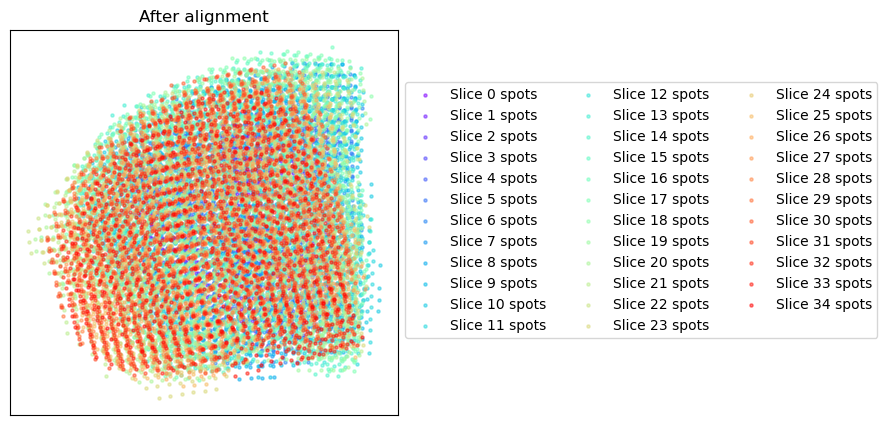

In [10]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw,
                                           data_type = "ST",
                                           coor_key="loc_use",
                                           plot=True)

In [11]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col="sample",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=slice_dist_micron,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)

Finding highly variable genes...
6227 highly variable genes selected.
Calculate basis for deconvolution...
6 batches are used for computing the basis vector of cell type <Astro_AMY>.
6 batches are used for computing the basis vector of cell type <Astro_AMY_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_HPC>.
6 batches are used for computing the basis vector of cell type <Astro_HYPO>.
4 batches are used for computing the basis vector of cell type <Astro_STR>.
5 batches are used for computing the basis vector of cell type <Astro_THAL_hab>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_lat>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_med>.
6 batches are used for computing the basis vector of cell type <Astro_WM>.
4 batches are used for computing the basis vector of cell type <Endo>.
6 batches are used for computing the basis 

In [12]:
model = STitch3D.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=100)

  0%|          | 1/2000 [00:11<6:22:15, 11.47s/it]

Step: 0, Loss: 5119.6094, d_loss: 5114.2051, f_loss: 54.0438


  5%|▌         | 101/2000 [16:24<4:55:20,  9.33s/it]

Step: 100, Loss: 3018.1335, d_loss: 3015.4082, f_loss: 27.2540


 10%|█         | 201/2000 [32:09<4:43:39,  9.46s/it]

Step: 200, Loss: 2252.7217, d_loss: 2250.0144, f_loss: 27.0721


 15%|█▌        | 301/2000 [47:01<4:11:51,  8.89s/it]

Step: 300, Loss: 1580.7887, d_loss: 1578.1019, f_loss: 26.8678


 20%|██        | 401/2000 [1:01:27<3:20:24,  7.52s/it]

Step: 400, Loss: 995.8650, d_loss: 993.1894, f_loss: 26.7561


 25%|██▌       | 501/2000 [1:13:58<3:07:16,  7.50s/it]

Step: 500, Loss: 496.7342, d_loss: 494.0686, f_loss: 26.6558


 30%|███       | 601/2000 [1:25:26<2:16:10,  5.84s/it]

Step: 600, Loss: 79.4504, d_loss: 76.7930, f_loss: 26.5742


 35%|███▌      | 701/2000 [1:35:19<2:05:15,  5.79s/it]

Step: 700, Loss: -264.6566, d_loss: -267.3063, f_loss: 26.4970


 40%|████      | 801/2000 [1:45:15<2:00:44,  6.04s/it]

Step: 800, Loss: -542.4492, d_loss: -545.0926, f_loss: 26.4336


 45%|████▌     | 901/2000 [1:55:36<1:49:54,  6.00s/it]

Step: 900, Loss: -763.0814, d_loss: -765.7472, f_loss: 26.6575


 50%|█████     | 1001/2000 [2:05:49<1:42:44,  6.17s/it]

Step: 1000, Loss: -941.5503, d_loss: -944.1870, f_loss: 26.3665


 55%|█████▌    | 1101/2000 [2:15:57<1:29:13,  5.96s/it]

Step: 1100, Loss: -1081.6802, d_loss: -1084.3145, f_loss: 26.3431


 60%|██████    | 1201/2000 [2:26:01<1:19:39,  5.98s/it]

Step: 1200, Loss: -1191.9810, d_loss: -1194.6136, f_loss: 26.3264


 65%|██████▌   | 1301/2000 [2:36:08<1:10:25,  6.05s/it]

Step: 1300, Loss: -1278.5023, d_loss: -1281.1332, f_loss: 26.3082


 70%|███████   | 1401/2000 [2:46:13<1:00:20,  6.04s/it]

Step: 1400, Loss: -1346.0784, d_loss: -1348.7069, f_loss: 26.2852


 75%|███████▌  | 1501/2000 [2:56:20<52:14,  6.28s/it]  

Step: 1500, Loss: -1399.4867, d_loss: -1402.1134, f_loss: 26.2669


 80%|████████  | 1601/2000 [3:06:25<40:40,  6.12s/it]

Step: 1600, Loss: -1441.3333, d_loss: -1443.9586, f_loss: 26.2540


 85%|████████▌ | 1701/2000 [3:16:33<29:29,  5.92s/it]

Step: 1700, Loss: -1475.4347, d_loss: -1478.0590, f_loss: 26.2424


 90%|█████████ | 1801/2000 [3:26:40<20:12,  6.09s/it]

Step: 1800, Loss: -1501.1411, d_loss: -1503.7631, f_loss: 26.2197


 95%|█████████▌| 1901/2000 [3:36:46<09:58,  6.04s/it]

Step: 1900, Loss: -1519.6383, d_loss: -1522.2690, f_loss: 26.3069


100%|██████████| 2000/2000 [3:46:47<00:00,  6.80s/it]


In [13]:
save_path = "./results/brain/raw"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)

In [88]:
# save adata_st

model.adata_st.write_h5ad(save_path + "/model.adata_st.h5ad")

In [14]:
count = pd.read_csv("./data/GSE147747_expr_raw_counts_table.tsv",
                    sep="\t", index_col=0)

meta = pd.read_csv("./data/GSE147747_meta_table.tsv",
                   sep="\t", index_col=0)

adata_st_all = ad.AnnData(X = count.values)

adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

sc.pp.filter_cells(adata_st_all, min_genes=1)

In [15]:
adata_st_list = []

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

for i in range(len(slice_use)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index==slice_use[i]]
    adata_st_i.obs.index = adata_st_i.obs.index + '-slice%d' % i
    adata_st_i.obs['section_id'] = i
    adata_st_list.append(adata_st_i)


In [16]:

latent = pd.read_csv(save_path+'/representation.csv', index_col=0)

adata_all = ad.concat([adata_st_list[i] for i in range(len(slice_use))], index_unique=None)
adata_all_raw = adata_all.copy()

adata_all = adata_all[latent.index]
adata_all_raw = adata_all_raw[latent.index]

In [89]:
latent

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
01A_20.48x20.11-slice0,10.225142,-5.602153,5.511760,-8.761139,-2.415738,-6.223626,-11.316984,4.209569,-5.360198,-6.944890,...,0.651795,1.831641,10.640778,-6.559257,1.156057,0.379625,4.814113,-8.338655,-3.913565,-2.612242
01A_21.45x20.11-slice0,10.346962,-5.617168,5.448210,-8.795898,-0.508655,-6.675491,-10.875536,4.593668,-5.527915,-6.499687,...,0.733846,2.367756,11.160919,-6.305601,2.645027,0.538068,4.781866,-8.308942,-3.575937,-2.916734
01A_19.34x20.15-slice0,10.134746,-5.616796,5.711060,-9.102368,-2.997496,-6.070799,-11.570783,3.493238,-5.301347,-7.057034,...,0.813639,1.334539,11.125794,-6.204389,0.446656,0.222188,4.036786,-8.393821,-4.083589,-2.460009
01A_18.37x20.18-slice0,9.885614,-5.782716,4.977269,-8.970146,-1.512782,-6.545599,-10.924334,4.297949,-5.155417,-6.415642,...,0.789029,3.090804,10.598153,-6.281497,0.382599,1.030275,4.351302,-8.534615,-3.571181,-3.111621
01A_21.44x21.14-slice0,11.117331,-6.226907,5.937783,-9.274474,-1.410431,-7.411708,-11.132984,4.076176,-5.586222,-7.220260,...,1.218602,1.995820,12.192108,-6.362138,1.200773,0.778099,5.192991,-9.092614,-3.938065,-3.599831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35A_14.81x29.15-slice34,14.482474,-6.658747,7.480421,-12.328846,7.218735,-7.277377,-10.189926,2.338053,-6.209833,-6.815138,...,0.491373,2.816537,18.339146,-6.455317,-3.314580,2.470357,-0.555688,-10.472923,-1.246871,-7.378532
35A_9.87x29.15-slice34,14.855603,-6.459436,7.920061,-12.953715,8.051323,-7.709462,-10.985034,3.702819,-6.654765,-7.646174,...,0.593922,3.381424,18.472183,-6.309911,-2.418415,2.910587,0.679248,-10.995998,-1.574234,-6.749434
35A_23.97x29.15-slice34,13.607295,-5.288907,6.528755,-11.018659,8.333142,-6.223691,-9.499038,-0.558344,-6.354989,-6.992175,...,-0.739808,3.427317,17.532450,-5.348076,-3.700246,2.289382,0.517878,-10.499104,0.996904,-7.052095
35A_11.99x29.18-slice34,14.893215,-6.068439,7.594800,-13.121065,8.601267,-7.747589,-11.134824,3.377437,-6.496930,-7.816275,...,0.227394,3.465509,18.213871,-6.533556,-2.779998,3.181942,0.369927,-11.319300,-0.625608,-7.048010


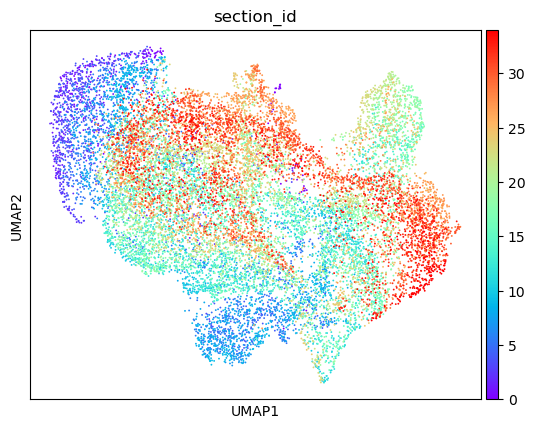

In [17]:
adata_all.obsm['latent'] = np.array(latent.values)

sc.pp.neighbors(adata_all, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color="section_id", color_map="rainbow")

In [133]:

sc.tl.louvain(adata_all, resolution=0.4)
#colours = ['#8c564b', '#ff7f0e', '#2ca02c', '#17becf', '#9467bd', '#1f77b4', '#e377c2', '#7f7f7f', '#bcbd22', '#d62728', '#aec7e8']


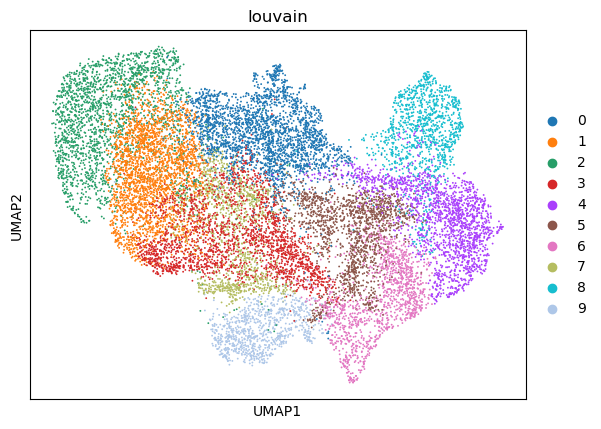

In [134]:
sc.pl.umap(adata_all, color="louvain",  color_map="rainbow")

In [135]:
model.adata_st

AnnData object with n_obs × n_vars = 17086 × 6227
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'n_genes', 'array_col', 'array_row', 'slice', 'batch', 'library_size'
    uns: 'log1p'
    obsm: 'spatial', 'loc_use', 'spatial_aligned', 'count', 'graph', '3D_coor', 'latent'

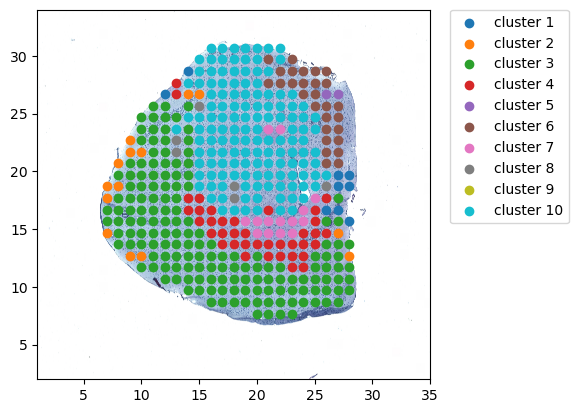

In [136]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459928_HE_06B.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
background = np.flipud(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "06B"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(10):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1]+2, label=f"cluster {i+1}")

# Match the background image
ax.imshow(background, extent=[1, 35, 2, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

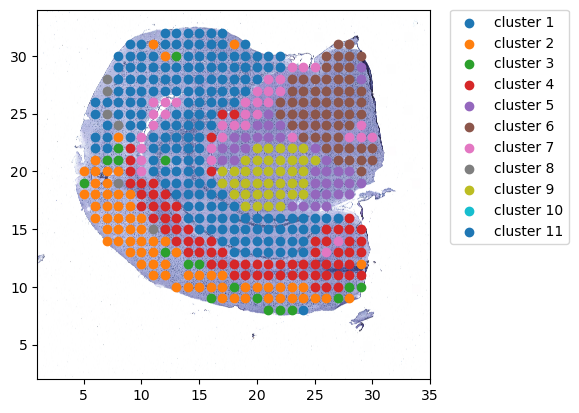

In [137]:

fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459964_HE_25A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)
#background = np.fliplr(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "25A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(11):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1] +1, label=f"cluster {i+1}")



# Match the background image
ax.imshow(background, extent=[1, 35, 2, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

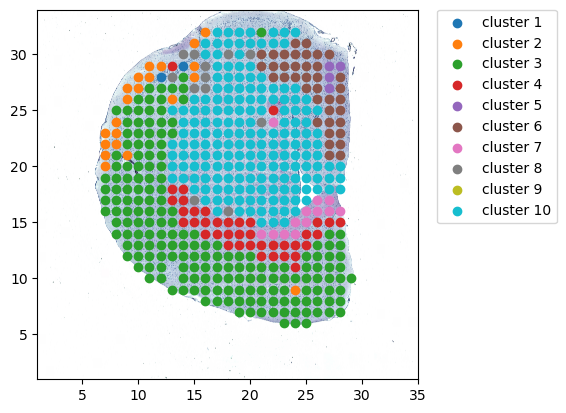

In [140]:
fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459929_HE_07A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "07A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(10):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1], label=f"cluster {i+1}")

# Match the background image
ax.imshow(background, extent=[1, 35, 1, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

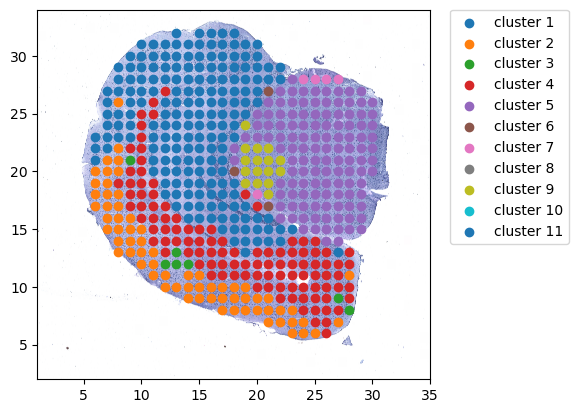

In [138]:


fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459967_HE_27A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)
#background = np.fliplr(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "27A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(11):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1] +1, label=f"cluster {i+1}")



# Match the background image
ax.imshow(background, extent=[1, 35, 2, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)